# ML Model Evaluation

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
version = '0.0.3'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

all = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])

# Load Models

In [3]:
knn = load('../classification_methods/models/KNN_7.0.2.joblib')
rfc = load('../classification_methods/models/RFC_7.0.2.joblib')
dtc = load('../classification_methods/models/DTC_7.0.2.joblib')

models = {'knn': knn, 'rfc': rfc, 'dtc': dtc}

## Mass Distribution Plots

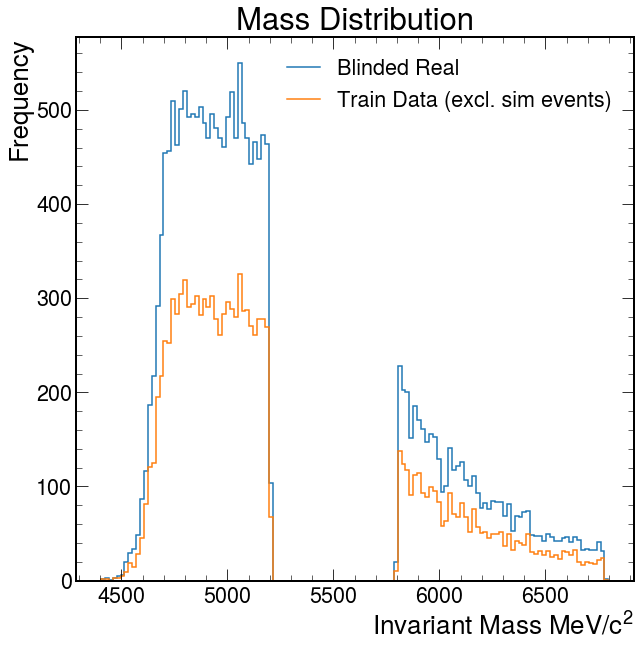

In [4]:
h_bg, bins = np.histogram(all['Lb_M'][all['IsSimulated']==False], bins=130)
h_bg_train, bins = np.histogram(train['Lb_M'][train['IsSimulated']==False], bins=bins)

fig, ax = plt.subplots(1, 1)
hep.histplot([h_bg, h_bg_train], bins=bins, ax=ax, label=['Blinded Real', 'Train Data (excl. sim events)'])
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.title('Mass Distribution')
#plt.savefig('../images/Normalisation/RealData_Before_And_After_Reblind.png')
plt.legend()
plt.show()

## No-Retraining Evaluation

In [5]:
predictions = {}

for model_name, model in models.items():
    predictions[model_name] = {
        'train': model.predict_proba(X_train)[:,1],
        'val': model.predict_proba(X_val)[:,1],
        'test': model.predict_proba(X_test)[:,1]
    }

### Accuracy & ROC-AUC Scores

In [6]:
for model_name, pred_dict in predictions.items():
    train_acc = accuracy_score(y_train, np.where(pred_dict['train']>0.5,1,0))
    val_acc = accuracy_score(y_val, np.where(pred_dict['val']>0.5,1,0))
    test_acc = accuracy_score(y_test, np.where(pred_dict['test']>0.5,1,0))
    
    trainroc = roc_auc_score(y_train, pred_dict['train'])
    valroc = roc_auc_score(y_val, pred_dict['val'])
    testroc = roc_auc_score(y_test, pred_dict['test'])
    
    print(f'{model_name.upper()}\n---------------------------\nTrain Accuracy: {train_acc:.4f}\nValidation Accuracy: {val_acc:.4f}\nTest Accuracy: {test_acc:.4f}')
    print(f'Train ROC-AUC: {trainroc:.4f}\nValidation ROC-AUC: {valroc:.4f}\nTest ROC-AUC: {testroc:.4f}')

KNN
---------------------------
Train Accuracy: 0.8561
Validation Accuracy: 0.8624
Test Accuracy: 0.8602
Train ROC-AUC: 0.9337
Validation ROC-AUC: 0.9396
Test ROC-AUC: 0.9380
RFC
---------------------------
Train Accuracy: 0.8527
Validation Accuracy: 0.8530
Test Accuracy: 0.8527
Train ROC-AUC: 0.9207
Validation ROC-AUC: 0.9263
Test ROC-AUC: 0.9233
DTC
---------------------------
Train Accuracy: 0.7958
Validation Accuracy: 0.7940
Test Accuracy: 0.7948
Train ROC-AUC: 0.8285
Validation ROC-AUC: 0.8306
Test ROC-AUC: 0.8319


### ROC Curves

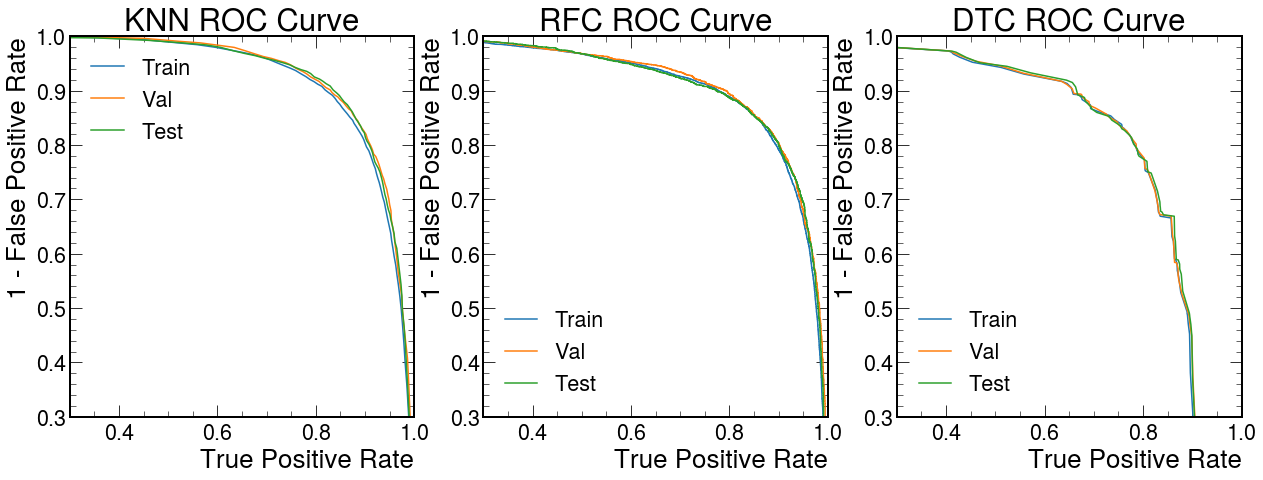

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

i = 0
for model_name, pred_dict in predictions.items():    
    trainroc = roc_curve(y_train, pred_dict['train'])
    valroc = roc_curve(y_val, pred_dict['val'])
    testroc = roc_curve(y_test, pred_dict['test'])
    
    ax[i].plot(trainroc[1], 1-trainroc[0], label='Train')
    ax[i].plot(valroc[1], 1-valroc[0], label='Val')
    ax[i].plot(testroc[1], 1-testroc[0], label='Test')
    ax[i].set_title(f'{model_name.upper()} ROC Curve')
    ax[i].set_ylabel('1 - False Positive Rate')
    ax[i].set_xlabel('True Positive Rate')
    ax[i].set_xlim(0.3,1)
    ax[i].set_ylim(0.3,1)
    ax[i].legend()
    
    i += 1

plt.show()

### Predicted Probabilities

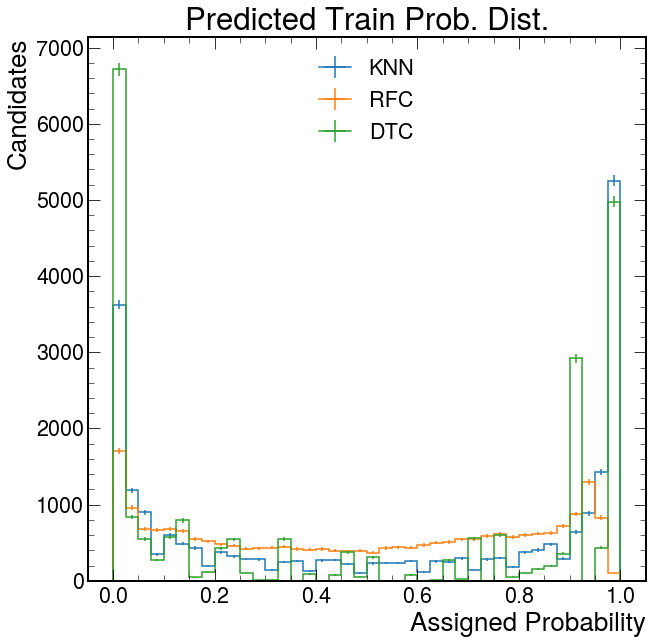

In [8]:
bins = np.linspace(0, 1, 41)

h = []
for model_name, pred_dict in predictions.items():
    h.append(np.histogram(pred_dict['train'], bins=bins)[0])

fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins=bins, yerr=[np.sqrt(i) for i in h], ax=ax, label=['KNN', 'RFC', 'DTC'])
plt.ylabel('Candidates')
plt.xlabel('Assigned Probability')
plt.legend(loc='upper center')
plt.title(f'Predicted Train Prob. Dist.')
#plt.savefig(f'../images/ModelEval/Pred_Prob_Dist_{version}.png', dpi=800)
plt.show()

## Retraining Models

In [10]:
knn.fit(X_train, y_train)
rfc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [11]:
models = {'knn': knn, 'rfc': rfc, 'dtc': dtc}
predictions = {}

for model_name, model in models.items():
    predictions[model_name] = {
        'train': model.predict_proba(X_train)[:,1],
        'val': model.predict_proba(X_val)[:,1],
        'test': model.predict_proba(X_test)[:,1]
    }

In [12]:
for model_name, pred_dict in predictions.items():
    train_acc = accuracy_score(y_train, np.where(pred_dict['train']>0.5,1,0))
    val_acc = accuracy_score(y_val, np.where(pred_dict['val']>0.5,1,0))
    test_acc = accuracy_score(y_test, np.where(pred_dict['test']>0.5,1,0))
    
    trainroc = roc_auc_score(y_train, pred_dict['train'])
    valroc = roc_auc_score(y_val, pred_dict['val'])
    testroc = roc_auc_score(y_test, pred_dict['test'])
    
    print(f'{model_name.upper()}\n---------------------------\nTrain Accuracy: {train_acc:.4f}\nValidation Accuracy: {val_acc:.4f}\nTest Accuracy: {test_acc:.4f}')
    print(f'Train ROC-AUC: {trainroc:.4f}\nValidation ROC-AUC: {valroc:.4f}\nTest ROC-AUC: {testroc:.4f}')

KNN
---------------------------
Train Accuracy: 0.9056
Validation Accuracy: 0.9113
Test Accuracy: 0.9100
Train ROC-AUC: 0.9737
Validation ROC-AUC: 0.9743
Test ROC-AUC: 0.9749
RFC
---------------------------
Train Accuracy: 0.9745
Validation Accuracy: 0.9231
Test Accuracy: 0.9198
Train ROC-AUC: 0.9969
Validation ROC-AUC: 0.9782
Test ROC-AUC: 0.9767
DTC
---------------------------
Train Accuracy: 0.9032
Validation Accuracy: 0.8861
Test Accuracy: 0.8808
Train ROC-AUC: 0.9627
Validation ROC-AUC: 0.9503
Test ROC-AUC: 0.9459


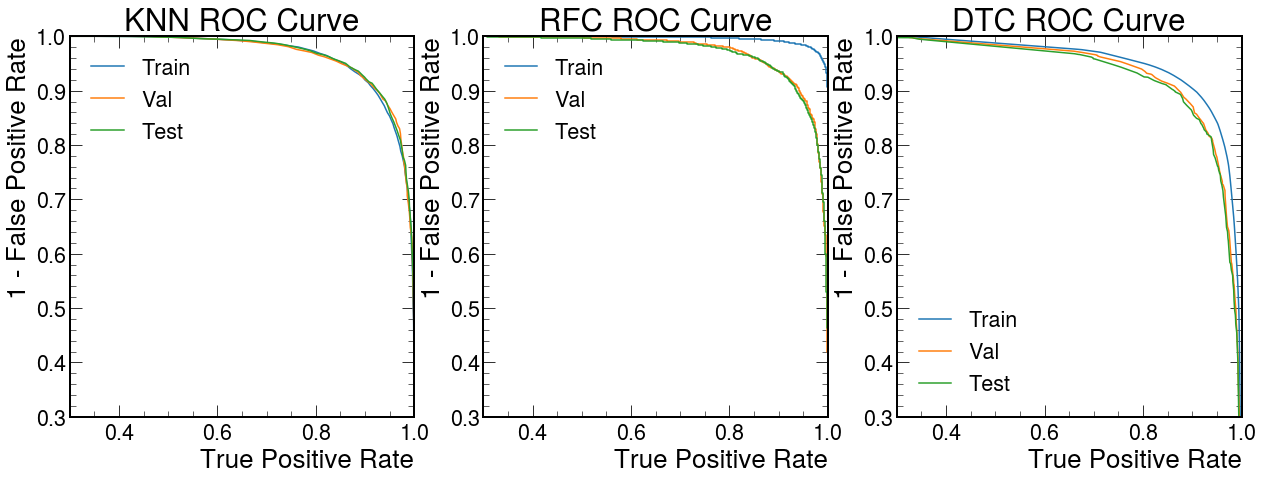

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

i = 0
for model_name, pred_dict in predictions.items():    
    trainroc = roc_curve(y_train, pred_dict['train'])
    valroc = roc_curve(y_val, pred_dict['val'])
    testroc = roc_curve(y_test, pred_dict['test'])
    
    ax[i].plot(trainroc[1], 1-trainroc[0], label='Train')
    ax[i].plot(valroc[1], 1-valroc[0], label='Val')
    ax[i].plot(testroc[1], 1-testroc[0], label='Test')
    ax[i].set_title(f'{model_name.upper()} ROC Curve')
    ax[i].set_ylabel('1 - False Positive Rate')
    ax[i].set_xlabel('True Positive Rate')
    ax[i].set_xlim(0.3,1)
    ax[i].set_ylim(0.3,1)
    ax[i].legend()
    
    i += 1

plt.show()

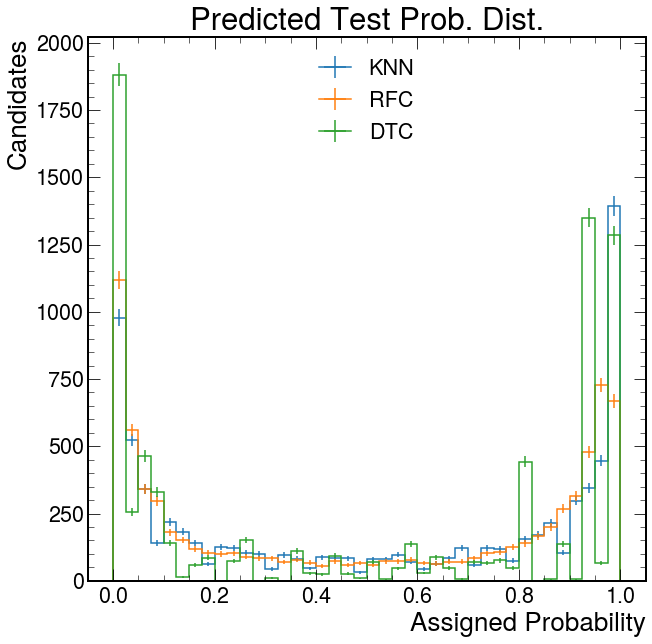

In [15]:
bins = np.linspace(0, 1, 41)

h = []
for model_name, pred_dict in predictions.items():
    h.append(np.histogram(pred_dict['test'], bins=bins)[0])

fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins=bins, yerr=[np.sqrt(i) for i in h], ax=ax, label=['KNN', 'RFC', 'DTC'])
plt.ylabel('Candidates')
plt.xlabel('Assigned Probability')
plt.legend(loc='upper center')
plt.title(f'Predicted Test Prob. Dist.')
#plt.savefig(f'../images/ModelEval/Pred_Prob_Dist_{version}.png', dpi=800)
plt.show()